# Proyek Machine Learning - Rifky Bujana Bisri
## Stack Overflow Question Quality Rating Prediction
situs Community Question Answering (CQA) menjadi salah satu jalan yang cukup populer untuk menyediakan dan mencari informasi. situs CQA menyediakan sebuah antarmuka untuk pengguna menukar dan berbagi pengetahuan. Pengguna menanyakan pertanyaan terhadap suatu topik yang kurang dia pahami, dan mencari seseorang yang ahli untuk memberikan informasi yang diinginkan. (Baltadzhieva & Chrupala, 2015)

Stack Overflow adalah sebuah situ CQA dalam lingkup computer programming. Pada Stack Overflow jawaban dipilih berdasarkan kepuasan penanya. Penanya dapat menandai sebuah pertanyaan untuk menunjukkan kepada sebuah subjek spesifik.

Namun, dengan meningkatnya popularitas Stack Overflow, jumlah pertanyaan yang tidak terjawab. Berdasarkan statistik pada 2012 saja, diperkirakan terdapat 45 pertanyaan setiap bulan tidak terjawab (Asaduzzaman, 2013). Pada Maret 2014, terdapat 752.533 dari 6.912.743 pertanyaan tidak terjawab (diperkirakan 10,9%) (Baltadzhieva & Chrupala, 2015). Yang menarik, pertanyaan yang tidak dijawab bukan disebabkan karena pengguna tidak melihatnya. Faktanya pertanyaan yang tidak terjawab rata-rata dilihat 139 kali (Asaduzzaman, 2013).

## Import Library

In [ ]:
import re
import string

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing import text, sequence
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support

## Loading Dataset

Memuat data set dari *Google Drive* untuk digunakan. Data set tersebut sudah terbagi menjadi 2: *train* data set dan *validation* data set.

In [ ]:
data_path = "./drive/MyDrive/Dicoding/"

In [ ]:
train_df = pd.read_csv(data_path + "train.csv")
valid_df = pd.read_csv(data_path + "valid.csv")

In [ ]:
df = pd.concat([train_df, valid_df])

## Data Understanding

Data set yang akan saya gunakan pada proyek ini merupakan dataset berisi enam puluh ribu pertanyaan pada *Stack Overflow* (45.000 *training dataset* dan 15.000 *validation dataset*), lengkap dengan *tag* dan tanggal pertanyaan itu di publish.

Dataset ini berisi 6 kolom berbeda: *Id*, *Title*, *Body*, *Tags*, *CreationDate*, dan *Y*. Kolom *Id* berisi identitas dari setiap baris untuk membedakan suatu baris dengan baris lainnya. Kolom *Title* berisi judul dari setiap pertanyaan. Kolom *Body* berisi detail ataupun isi dari pertanyaan yang diajukan dengan format *html*. *Tags* berisi *tags* yang berhubungan dengan pertanyaan tersebut. *CreationDate* berisi tanggal diunggahnya pertanyaan tersebut dengan format *UTC*. Dan kolom *Y* berisi tingkat kualitas pertanyaan yang dibagi menjadi 3, yaitu: *HQ*, *LQ_EDIT*, dan *LQ_CLOSE*.

*HQ* merupakan postingan pertanyaan berkualitas tinggi dengan total skor lebih dari 30 dan tanpa diedit sekalipun. *LQ_EDIT* merupakan postingan berkualitas rendah dengan skor negatif dan diedit beberapa kali oleh komunitas. Namun, postingan tersebut masih terbuka setelah diubah oleh komunitas. Sedangkan *LQ_CLOSE* merupakan postingan berkualitas rendah yang ditutup oleh komunitas tanpa diedit sama sekali.

[dataset](https://www.kaggle.com/imoore/60k-stack-overflow-questions-with-quality-rate)

In [ ]:
df.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [ ]:
df.columns

Index(['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'Y'], dtype='object')

Manggabungkan data judul dan isi dari pertanyaan

In [ ]:
# combine title and body
df['text'] = df['Title'] + " " + df['Body']

# drop unused columns
df.drop(['Id', 'Tags', 'CreationDate', 'Title', 'Body'], axis=1, inplace=True)

# rename Y into label
df.rename(columns={"Y":"label"}, inplace=True)

In [ ]:
print("Total Data: ", len(df))
df.head()

Total Data:  60000


,label,text
0,LQ_CLOSE,Java: Repeat Task Every Random Seconds <p>I'm ...
1,HQ,Why are Java Optionals immutable? <p>I'd like ...
2,HQ,Text Overlay Image with Darkened Opacity React...
3,HQ,Why ternary operator in swift is so picky? <p>...
4,HQ,hide/show fab with scale animation <p>I'm usin...


Distribusi data untuk setiap kategori, dapat dilihat pada diagram dibawah jumlah data pada masing-masing kategori sangat seimbang.

<BarContainer object of 3 artists>

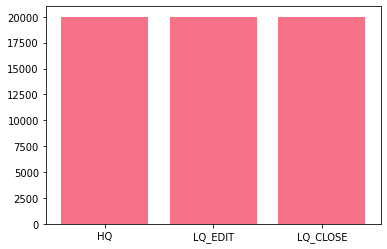

In [ ]:
plt.bar(
    ['HQ', 'LQ_EDIT', 'LQ_CLOSE'],
    df['label'].value_counts()
)

Jumlah kata dalam setiap postingan terlihat cukup seimbang.

In [ ]:
word_count = [
    ['HQ', [len(x) if len(x) < 500 else 500 for x in df[df['label']=='HQ']['text'].str.split()]],
    ['LQ_EDIT', [len(x) if len(x) < 500 else 500 for x in df[df['label']=='LQ_EDIT']['text'].str.split()]],
    ['LQ_CLOSE', [len(x) if len(x) < 500 else 500 for x in df[df['label']=='LQ_CLOSE']['text'].str.split()]]
]

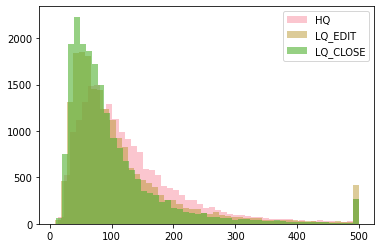

In [ ]:
for i, count in enumerate(word_count):
    plt.hist(count[1], bins=50, label=count[0], alpha=0.4 + (i * 0.1))

plt.legend()
plt.show()

### N-Gram Analysis

Saya menggunakan n-gram untuk menganalisa isi teks dari data masing-masing kategori. Saya mengambil top 20 unigram dan bigram dari masing-masing kategori untuk mendapatkan gambaran penggunaan kata pada masing-masing kategori.

In [ ]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

In [ ]:
def display_chart(title, data, index, ax):
    ax.set_title(title)
    ax.bar(
        list(data[index].keys()),
        list(data[index].values())
    )

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

#### Unigram

In [ ]:
unigram = [
    dict(get_top_text_ngrams(
        df[df['label'] == 'HQ']['text'].values, 20, 1
    )),
    dict(get_top_text_ngrams(
        df[df['label'] == 'LQ_EDIT']['text'].values, 20, 1
    )),
    dict(get_top_text_ngrams(
        df[df['label'] == 'LQ_CLOSE']['text'].values, 20, 1
    )),
]

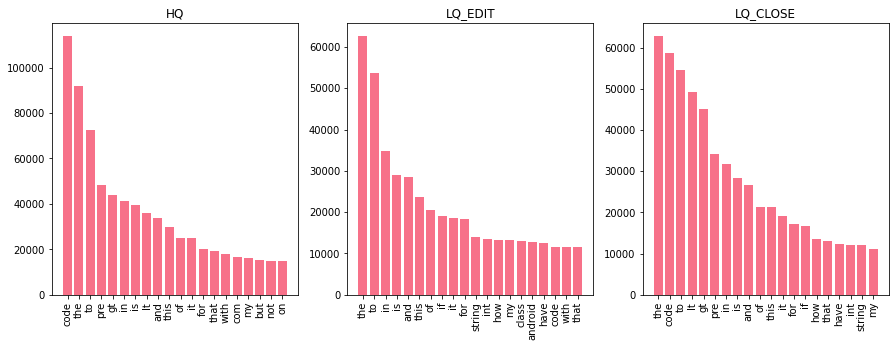

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

display_chart("HQ", unigram, 0, ax1)
display_chart("LQ_EDIT", unigram, 1, ax2)
display_chart("LQ_CLOSE", unigram, 2, ax3)

#### Bigram

In [ ]:
bigram = [
    dict(get_top_text_ngrams(
        df[df['label'] == 'HQ']['text'].values, 20, 2
    )),
    dict(get_top_text_ngrams(
        df[df['label'] == 'LQ_EDIT']['text'].values, 20, 2
    )),
    dict(get_top_text_ngrams(
        df[df['label'] == 'LQ_CLOSE']['text'].values, 20, 2
    )),
]

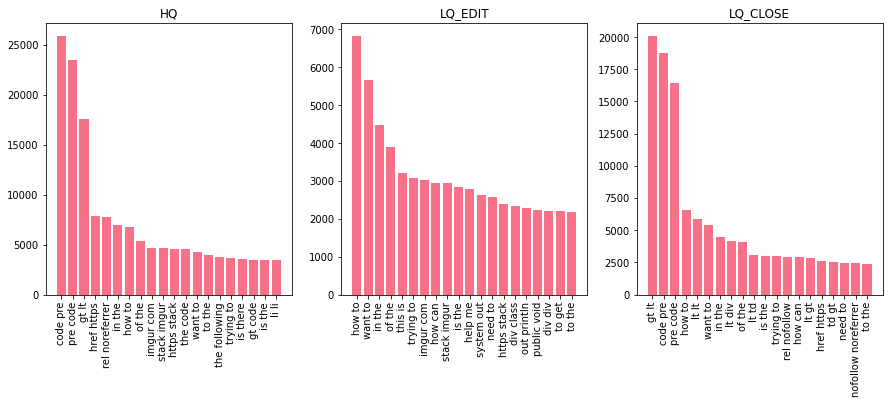

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

display_chart("HQ", bigram, 0, ax1)
display_chart("LQ_EDIT", bigram, 1, ax2)
display_chart("LQ_CLOSE", bigram, 2, ax3)

## Data Preparation

Melihat apakah terdapat data kosong pada data set

In [ ]:
df.isna().sum()

label    0
text     0
dtype: int64

Seperti yang kita lihat pada bagian *Data Understanding*, data yang saya miliki memiliki format *html*. Oleh karena itu teks tersebut perlu dibersihkan dari simbol dan *tag html*, dan membuat semua huruf didalamnya menjadi huruf kecil. Jika teks berada dalam huruf besar/kecil yang sama, lebih mudah bagi mesin untuk menafsirkan kata-kata karena huruf kecil dan huruf besar diperlakukan berbeda oleh mesin.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]','', text)
    return text
    
df['text'] = df['text'].apply(clean_text)

***Label encoding***, metode ini mengacu pada pengubahan label menjadi bentuk numerik untuk mengubahnya menjadi bentuk yang dapat dibaca mesin. Algoritma machine learning kemudian dapat memutuskan dengan cara yang lebih baik bagaimana label tersebut harus dioperasikan.

In [ ]:
label_encoder = preprocessing.LabelEncoder() 
df['label'] = label_encoder.fit_transform(df['label'])  

Hasil akhir dari data yang telah diproses adalah sebagai berikut, terlhiat label yang digunakan pada data sudah tidak berbentuk teks melainkan dalam bentuk angka. Lalu, pada teks sudah tidak terlihat simbol ataupun tag dari *html*.

In [ ]:
df.head()

,label,text
0,1,java repeat task every random seconds pim alre...
1,0,why are java optionals immutable pid like to u...
2,0,text overlay image with darkened opacity react...
3,0,why ternary operator in swift is so picky pthe...
4,0,hideshow fab with scale animation pim using cu...


In [ ]:
df['label'].unique()

array([1, 0, 2])

Membagi dataset menjadi 2 bagian, yaitu: *training dataset* dan *validation dataset*. *Training dataset* digunakan untuk melatih model terhadap data, sedangkan *validation dataset* digunakan untuk mengevaluasi kemampuan dari model dalam memprediksi data.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    df['text'], 
    df['label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

### Tokenizing

tokenisasi adalah proses untuk membagi teks yang dapat berupa kalimat, paragraf atau dokumen, menjadi token-token/bagian-bagian tertentu. Masing-masing *token* dalam teks tersebut kemudian akan diproses lagi menggunakan *TF-IDF* untuk memberikan informasi kepada model bobot dari setiap *token*.

*TF-IDF* adalah suatu metode algoritma yang berguna untuk menghitung bobot setiap kata yang umum digunakan. Metode ini juga terkenal efisien, mudah dan memiliki hasil yang akurat. Metode ini akan menghitung nilai *Term Frequency* (*TF*) dan *Inverse Document Frequency* (*IDF*) pada setiap token (kata) di setiap dokumen dalam korpus. Secara sederhana, metode *TF-IDF* digunakan untuk mengetahui berapa sering suatu kata muncul di dalam dokumen.

In [ ]:
max_features = 10000

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)

In [ ]:
# Menyesuaikan tokenizer dengan training dataset
tokenizer.fit_on_texts(x_train)

In [ ]:
# mengaplikasikan tokenization terhadap training dataset
tokenized_train = tokenizer.texts_to_sequences(x_train)

# mengaplikasikan tf-idf terhadap data yang sudah ditokenisasi (Logistic Regression)
x_tfidf_train = tokenizer.sequences_to_matrix(tokenized_train, mode='tfidf')

In [ ]:
# mengaplikasikan tokenization terhadap validation dataset
tokenized_test = tokenizer.texts_to_sequences(x_test)

# mengaplikasikan tf-idf terhadap data yang sudah ditokenisasi (Logistic Regression)
X_tfidf_test = tokenizer.sequences_to_matrix(tokenized_test, mode='tfidf')

## Modelling

### Logistic Regression



> Logistic Regression

*Logistic Regression* merupakan salah satu metode yang dapat digunakan untuk mencari hubungan variabel respon yang bersifat dichotomous (berskala nominal atau ordinal dengan dua kategori) atau polychotomous (mempunyai skala nominal atau ordinal dengan lebih dari dua kategori) dengan satu atau lebih variabel prediktor dan variabel respon bersifat kontinyu atau kategorik.

> Multinomial Logistic Regression

*Multinomial logistic regression* atau disebut juga model logit politomus adalah model regresi yang digunakan untuk menyelesaikan kasus regresi dengan variabel dependen berupa data kualitatif berbentuk multinomial (lebih dari dua kategori) dengan satu atau lebih variabel independen

sumber: https://medium.com/@wahyudhizainal/analisis-regresi-logistik-multinomial-dengan-spss-cb65fb246b69

In [ ]:
# define multinomial logistic regression model
lr_model = LogisticRegression(multi_class='multinomial')

In [ ]:
# train model towards TF-IDF dataset
lr_model.fit(x_tfidf_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Naive Bayes

Metode Multinomial Naive Bayes merupakan variasi lain dari Naive Bayes. Metode ini mengasumsikan bahwa semua atribut saling bergantung satu sama lain mengingat konteks kelas, dan mengabaikan semua dependensi antar atribut (Saleh, A. 2014).

In [ ]:
nb_model = MultinomialNB()

In [ ]:
nb_model.fit(x_tfidf_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Evaluation

### Logistic Regression

Setelah dites terhadap dataset test yang diperlakukan sama dengan training dataset, model logistic regression berhasil mendapatkan tingkat akurasi yang cukup baik yaitu sebesar 87,30%.

In [ ]:
print(f"Test Accuracy: {(lr_model.score(X_tfidf_test, y_test)) * 100:.2f}%")

Test Accuracy: 87.30%


Lalu, jika kita menganalisa hasil prediksi model terhadap label data menggunakan confusion matrix. Terlihat bahwa model dapat memprediksi kategori 2 (LQ_EDIT) dengan sangat baik, tetapi model cukup kebingungan dalam memprediksi beberapa data kategori 0 (HQ) dan 1 (LQ_CLOSE).

Jika kita kembali melihat pada gambar unigram dan bigram kategori 0 (HQ) dan 1 (LQ_CLOSE) memang terlihat kemiripan diantara keduanya. Namun, jumlah data yang diprediksi oleh model dengan benar masih cukup baik.

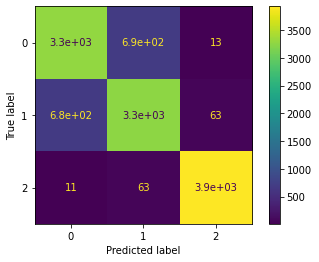

In [ ]:
plot_confusion_matrix(lr_model, X_tfidf_test, y_test)

Keterangan:
- 0 = HQ
- 1 = LQ_CLOSE
- 2 = LQ_EDIT

In [208]:
precision_recall_fscore_support(y_test, lr_model.predict(X_tfidf_test))

(array([0.82622869, 0.8117207 , 0.9810095 ]),
 array([0.82375, 0.81375, 0.9815 ]),
 array([0.82498748, 0.81273408, 0.98125469]),
 array([4000, 4000, 4000]))

### Naive Bayes

Setelah dites terhadap dataset test yang diperlakukan sama dengan training dataset, model naive bayes berhasil mendapatkan tingkat akurasi yang cukup baik yaitu sebesar 86,37%. Akurasi tersebut sedikit lebih kecil dari tingkat akurasi dari model logistic regression.

In [ ]:
print(f"Test Accuracy: {(nb_model.score(X_tfidf_test, y_test)) * 100:.2f}%")

Test Accuracy: 86.37%


Lalu, jika kita menganalisa hasil prediksi model terhadap label data menggunakan confusion matrix. Terlihat bahwa model dapat memprediksi kategori 2 (LQ_EDIT) dengan sangat baik, tetapi saat model memprediksi data kategori 0 (HQ) dan 1 (LQ_CLOSE) model cukup kebingungan dalam membedakan beberapa data kategori 0 (HQ) dan 1 (LQ_CLOSE). Dan model juga melakukan kesalahan pada data kategori 0 (HQ) dan 1 (LQ_CLOSE) dengan memprediksinya sebagai data kategori 2 (HQ_EDIT) walau lebih sedikit daripada antara kategori 0 (HQ) dan 1 (LQ_EDIT).

Jika kita kembali melihat pada gambar unigram dan bigram kategori 0 (HQ) dan 1 (LQ_CLOSE) memang terlihat kemiripan diantara keduanya. Namun, jumlah data yang diprediksi oleh model dengan benar masih cukup baik.

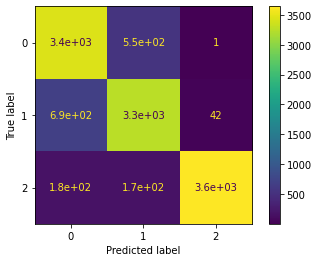

In [ ]:
plot_confusion_matrix(nb_model, X_tfidf_test, y_test)

Keterangan:
- 0 = HQ
- 1 = LQ_CLOSE
- 2 = LQ_EDIT

In [209]:
precision_recall_fscore_support(y_test, nb_model.predict(X_tfidf_test))

(array([0.7987028 , 0.81881882, 0.9883374 ]),
 array([0.862, 0.818, 0.911]),
 array([0.82914512, 0.8184092 , 0.94809418]),
 array([4000, 4000, 4000]))

## Kesimpulan

- Model logistic regression dapat memprediksi data lebih baik dari pada model naive bayes. Hal ini dapat dilihat dari tingkat akurasi logistic regression yang sedikit lebih tinggi dari model naive bayes. Hal tersebut juga dapat dilihat dimana model naive bayes melakukan jauh lebih banyak kesalahan dalam memprediksi label HQ dan LQ_CLOSE menjadi label LQ_EDIT.
- Model machine learning dapat memprediksi kualitas pertanyaan pada *Stack Overflow* dengan cukup baik.
- Model machine learning bisa menjadi salah satu solusi dalam memberikan masukan untuk melakukan keputusan terhadap suatu postingan di *Stack Overflow*.